## Part1 模型训练
这部分首先进行一些基础参数的设定，为后续的训练做好全局变量上的准备。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models import *
import wandb
import time
from torch.amp import autocast, GradScaler
import csv
import sys

In [2]:
LR = 0.01
RESUME = False
BATCH_SIZE = 256
EPOCHS = 200
DTYPE = 'fp16'
MODEL = 'VGG19'
LOSS_SCALE = True
AMP = True
DATASET='Cifar10'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

接下来准备好一些初始化

In [5]:
run_name=f'Cifar10-{MODEL}-e{EPOCHS}-b{BATCH_SIZE}-'+DTYPE
if AMP:
    run_name += '-amp'
if LOSS_SCALE:
    run_name += '-lossscale'
run_name

'Cifar10-VGG19-e200-b256-fp16-amp-lossscale'

In [6]:
if DTYPE=="fp32":
    dtype=torch.float32
elif DTYPE=="fp16":
    dtype=torch.float16
elif DTYPE=="bf16":
    dtype=torch.bfloat16

准备数据

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')
device

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


'cuda'

准备模型

In [8]:
# Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
print('==> Building model..')
model_dict = {
    'VGG19': VGG('VGG19'),
    'ResNet18': ResNet18(),
    'PreActResNet18': PreActResNet18(),
    'GoogLeNet': GoogLeNet(),
    'DenseNet121': DenseNet121(),
    'ResNeXt29_2x64d': ResNeXt29_2x64d(),
    'MobileNet': MobileNet(),
    'MobileNetV2': MobileNetV2(),
    'DPN92': DPN92(),
    # 'ShuffleNetG2': ShuffleNetG2(),
    'SENet18': SENet18(),
    'ShuffleNetV2': ShuffleNetV2(1),
    'EfficientNetB0': EfficientNetB0(),
    'RegNetX_200MF': RegNetX_200MF(),
    'SimpleDLA': SimpleDLA()
}

net = model_dict.get(MODEL, VGG('VGG19'))  
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if RESUME:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('demo-checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./demo-checkpoint/{run_name}-ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

==> Building model..


优化器准备

In [9]:
if AMP and LOSS_SCALE:
    scaler = GradScaler()
else:
    scaler = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR,
                    momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

log 文件函数定义

In [10]:
def setup_directories(run_name):
    # 定义主目录路径
    base_dir = 'demo-results1'

    # 创建 results 目录（如果不存在）
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # 创建run_name文件夹（如果不存在）
    run_dir = os.path.join(base_dir, run_name)
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
    
    # 创建 CSV 文件和 Log 文件
    train_csv = os.path.join(run_dir, 'train.csv')
    test_step_csv = os.path.join(run_dir, 'test_step.csv')
    test_epoch_csv = os.path.join(run_dir, 'test_epoch.csv')
    log_file = os.path.join(run_dir, 'log.txt')
    
    # 创建 train.csv 和 test.csv 文件并写入表头
    for csv_file, header in zip([train_csv, test_step_csv, test_epoch_csv], [['train_loss', 'train_accuracy'], ['test_loss', 'test_accuracy'], ['epoch', 'test_accuracy']]):
        # if not os.path.exists(csv_file):
        with open(csv_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(header)
    
    # 创建或清空 log.txt 文件
    # if not os.path.exists(log_file):
    with open(log_file, 'w') as file:
        file.write('Training Log\n' + '='*20 + '\n')
    
    # train_csv = open(train_csv, mode='a', newline='')
    # test_step_csv = open(test_step_csv, mode='a', newline='')
    # test_epoch_csv = open(test_epoch_csv, mode='a', newline='')
    # log_file = open(log_file, mode='a')
    return train_csv, test_step_csv, test_epoch_csv, log_file

def log_to_file(log_file, message):
    with open(log_file, 'a') as f:
        f.write(message + '\n')

def log_print_output(log_file):
    # 重定向 stdout 到 log.txt
    sys.stdout = open(log_file, 'a')

log文件准备

In [11]:
train_csv, test_step_csv, test_epoch_csv, log_file = setup_directories(run_name=run_name)
# with open(train_csv, mode='a', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow([0,1])
    

定义train函数

In [12]:
# Training
def train(epoch):
    global net, scaler, optimizer, scheduler, dtype, train_csv, test_step_csv, test_epoch_csv, log_file
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    # when use amp don't let the tensor be fp16, let amp decide it
    if not AMP:
        net = net.to(dtype)
    train_list = []
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if not AMP:
            inputs, targets = inputs.to(device).to(dtype), targets.to(device)
        else:
            inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        if AMP:
            with autocast(device_type='cuda', dtype=dtype):
                outputs = net(inputs)
                loss = criterion(outputs, targets)
            if LOSS_SCALE:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
        else:
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total), end='\r', flush=True)
        # log train loss and acc
        train_list.append([train_loss/(batch_idx+1), correct/total])
    with open(train_csv, mode='a', newline='') as file:
        for item in train_list:
            csv_writer = csv.writer(file)
            csv_writer.writerow(item)
        
    # log training time spent per epoch
    # log_file.write(f"epoch:{epoch}\ttime(s/epoch): {end-start}\n")

定义test函数

In [13]:
def test(epoch):
    global best_acc, net, dtype, train_csv, test_step_csv, test_epoch_csv, log_file
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_loss_list = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # when use amp don't let the tensor be fp16, let amp decide it
            if not AMP:
                inputs, targets = inputs.to(device).to(dtype), targets.to(device)
            else:
                inputs, targets = inputs.to(device), targets.to(device)
            if AMP:
                with autocast(device_type='cuda', dtype=dtype):
                    outputs = net(inputs)
            else:
                outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total), end='\r', flush=True)
            # log test loss and accuracy
            test_loss_list.append([test_loss/(batch_idx+1), correct/total])
    with open(test_step_csv, mode='a', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow([test_loss/(batch_idx+1), correct/total])
    # Save checkpoint.
    acc = 100.*correct/total
    with open(test_epoch_csv, mode='a', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow([epoch, correct/total])
    if acc > best_acc:
        print()
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('demo-checkpoint'):
            os.mkdir('demo-checkpoint')
        torch.save(state, f'./demo-checkpoint/{run_name}-ckpt.pth')
        best_acc = acc
        with open(log_file, mode='a') as file:
            file.write(f"epoch: {epoch}\tbest_acc: {best_acc}\n")


## 训练开始

In [14]:
total_st = time.time()
for epoch in range(start_epoch, start_epoch+EPOCHS):
    train(epoch)
    test(epoch)
    scheduler.step()
total_time = time.time()-total_st
with open(log_file, mode='a') as file:
    file.write(f"total training and test time: {total_time} s\n")


Epoch: 0


Loss: 1.433 | Acc: 51.340% (5134/10000))
Saving..

Epoch: 1
Loss: 0.996 | Acc: 65.680% (6568/10000))
Saving..

Epoch: 2
Loss: 0.746 | Acc: 74.480% (7448/10000))
Saving..

Epoch: 3
Loss: 0.848 | Acc: 71.790% (7179/10000))
Epoch: 4
Loss: 0.653 | Acc: 77.490% (7749/10000))
Saving..

Epoch: 5
Loss: 0.728 | Acc: 75.660% (7566/10000))
Epoch: 6
Loss: 0.637 | Acc: 78.620% (7862/10000))
Saving..

Epoch: 7
Loss: 0.584 | Acc: 80.060% (8006/10000))
Saving..

Epoch: 8
Loss: 0.520 | Acc: 82.600% (8260/10000))
Saving..

Epoch: 9
Loss: 0.489 | Acc: 83.740% (8374/10000))
Saving..

Epoch: 10
Loss: 0.530 | Acc: 82.740% (8274/10000))
Epoch: 11
Loss: 0.431 | Acc: 85.390% (8539/10000))
Saving..

Epoch: 12
Loss: 0.491 | Acc: 84.150% (8415/10000))
Epoch: 13
Loss: 0.440 | Acc: 85.750% (8575/10000))
Saving..

Epoch: 14
Loss: 0.490 | Acc: 84.730% (8473/10000))
Epoch: 15
Loss: 0.440 | Acc: 85.990% (8599/10000))
Saving..

Epoch: 16
Loss: 0.448 | Acc: 85.890% (8589/10000))
Epoch: 17
Loss: 0.399 | Acc: 87.170% (8717

## 训练结束后，对训练结果进行可视化

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import argparse

定义test accuracy绘制函数

In [16]:
def plot_test_acc(exp_dir, save_dir):
    global prefix
    plt.figure(figsize=(10, 6))
    color_dict = {
        'FP32': '#7EC8E3',  # 浅蓝色
        'FP16-AMP': '#FFB37A',  # 浅橙色
        'FP16-AMP-LOSS_SCALE': '#A3D9A5',  # 浅绿色
        'BF16-AMP': '#F28C8C',  # 浅红色
        'FP16': '#B59DD7',  # 浅紫色
        'BF16': '#D9A69A'  # 浅棕色
    }

    all_data = []
    for dir in exp_dir:
        df = pd.read_csv(f"{dir}/test_epoch.csv")
        if 'fp32' in dir:
            label = 'FP32'
        elif 'fp16-amp-lossscale' in dir:
            label = 'FP16-AMP-LOSS_SCALE'
        elif 'fp16-amp' in dir:
            label = 'FP16-AMP'
        elif 'bf16-amp' in dir:
            label = 'BF16-AMP'
        elif 'fp16' in dir:
            label = 'FP16'
        elif 'bf16' in dir:
            label = 'BF16'
        plt.plot(df['epoch'], df['test_accuracy'], label=label, color=color_dict[label])

        all_data.append((df['epoch'], df['test_accuracy'], label))

    plt.title(f'Test Accuracy vs Epoch for Different Precision Models(epoch: {EPOCHS}, batch-size:{BATCH_SIZE})')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.grid(True)
    
    # 获取最后的几个 epoch 数据来做放大镜
    zoom_start = 180  # 假设最后 20 个 epoch 需要放大
    zoom_end = 200    # 调整这个范围来控制放大区域

    # 创建 inset_axes 用于显示放大镜区域
    axins = inset_axes(plt.gca(), width="30%", height="30%", loc='lower left', bbox_to_anchor=(0.65, 0.4, 1, 1), bbox_transform=plt.gca().transAxes, borderpad=2)

    # 在放大镜区域绘制最后的 epoch 数据
    for epoch_data, accuracy_data, label in all_data:
        axins.plot(epoch_data[zoom_start:zoom_end], accuracy_data[zoom_start:zoom_end], label=label, color=color_dict[label])

    # 放大镜标记
    mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")  # loc1和loc2指定放大区域的边框位置

    # 放大镜图例和标注
    axins.set_title('Zoomed In Area')
    axins.set_xlabel('Epoch')
    axins.set_ylabel('Test Accuracy')
    plt.show()
    plt.savefig(f'{save_dir}/{prefix}test_acc.png')

定义train loss绘制函数

In [17]:
def plot_train_loss_acc(exp_dir, save_dir):
    global prefix
    plt.figure(figsize=(10, 6))
    color_dict = {
        'FP32': '#7EC8E3',  # 浅蓝色
        'FP16-AMP': '#FFB37A',  # 浅橙色
        'FP16-AMP-LOSS_SCALE': '#A3D9A5',  # 浅绿色
        'BF16-AMP': '#F28C8C',  # 浅红色
        'FP16': '#B59DD7',  # 浅紫色
        'BF16': '#D9A69A'  # 浅棕色
    }

    all_data = []
    for dir in exp_dir:
        df = pd.read_csv(f"{dir}/train.csv")
        if 'fp32' in dir:
            label = 'FP32'
        elif 'fp16-amp-lossscale' in dir:
            label = 'FP16-AMP-LOSS_SCALE'
        elif 'fp16-amp' in dir:
            label = 'FP16-AMP'
        elif 'bf16-amp' in dir:
            label = 'BF16-AMP'
        elif 'fp16' in dir:
            label = 'FP16'
        elif 'bf16' in dir:
            label = 'BF16'
        df['step'] = range(len(df))
        plt.plot(df['step'], df['train_loss'], label=label, color=color_dict[label])

        all_data.append((df['step'], df['train_loss'], label))

    plt.title(f'Train Loss vs Step for Different Precision Models(epoch: {EPOCHS}, batch-size:{BATCH_SIZE})')
    plt.xlabel('Step')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.grid(True)

    # 获取最后的几个 epoch 数据来做放大镜
    zoom_start = len(df)-20  # 假设最后 20 个 epoch 需要放大
    zoom_end = len(df)    # 调整这个范围来控制放大区域

    # 创建 inset_axes 用于显示放大镜区域
    axins = inset_axes(plt.gca(), width="30%", height="30%", loc='lower left', bbox_to_anchor=(0.65, 0.4, 1, 1), bbox_transform=plt.gca().transAxes, borderpad=2)

    # 在放大镜区域绘制最后的 epoch 数据
    for epoch_data, accuracy_data, label in all_data:
        axins.plot(epoch_data[zoom_start:zoom_end], accuracy_data[zoom_start:zoom_end], label=label, color=color_dict[label])

    # 放大镜标记
    mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")  # loc1和loc2指定放大区域的边框位置

    # 放大镜图例和标注
    axins.set_title('Zoomed In Area')
    axins.set_xlabel('Step')
    axins.set_ylabel('Train Loss')
    plt.show()

    plt.savefig(f'{save_dir}/{prefix}train_loss.png')

In [18]:
EXP_DIR='demo-results1'
SAVE_DIR='./demo-visualize'
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)
# suffix_list = ["fp32", "fp16", "bf16", "fp16-amp", "bf16-amp", "fp16-amp-lossscale"]
suffix_list = ["fp16-amp-lossscale"]
prefix = f'{DATASET}-{MODEL}-e{EPOCHS}-b{BATCH_SIZE}-'
exp_list = [f'{EXP_DIR}/{prefix+suffix_list[i]}' for i in range(len(suffix_list))]


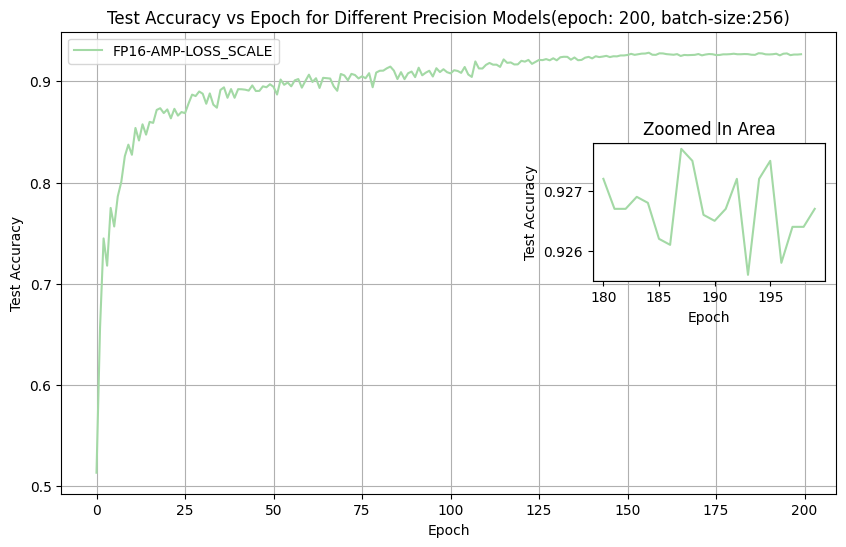

<Figure size 640x480 with 0 Axes>

In [20]:
plot_test_acc(exp_list, SAVE_DIR)

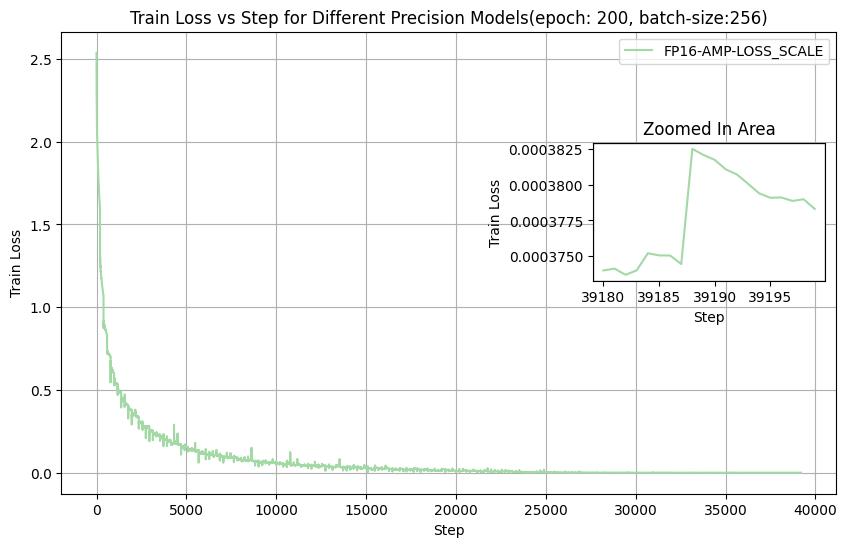

<Figure size 640x480 with 0 Axes>

In [19]:
plot_train_loss_acc(exp_list, SAVE_DIR)